In [1]:
!git clone https://github.com/NMADALI97/Blood-Cell-Detection

Cloning into 'Blood-Cell-Detection'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 17 (delta 5), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [2]:
import os
os.chdir("Blood-Cell-Detection")
import sys
import numpy as np
from preprocessing import parse_annotation, BatchGenerator
import pandas as pd
import cv2
cv2.setUseOptimized(True);
cv2.setNumThreads(4);
import matplotlib.pyplot as plt


!unzip BCCD_Dataset-master.zip


Using TensorFlow backend.


Archive:  BCCD_Dataset-master.zip
d272fb14cdff6e473fafeeeba32aba5f560e9e43
   creating: BCCD_Dataset-master/
 extracting: BCCD_Dataset-master/.gitignore  
   creating: BCCD_Dataset-master/BCCD/
   creating: BCCD_Dataset-master/BCCD/Annotations/
  inflating: BCCD_Dataset-master/BCCD/Annotations/BloodImage_00000.xml  
  inflating: BCCD_Dataset-master/BCCD/Annotations/BloodImage_00001.xml  
  inflating: BCCD_Dataset-master/BCCD/Annotations/BloodImage_00002.xml  
  inflating: BCCD_Dataset-master/BCCD/Annotations/BloodImage_00003.xml  
  inflating: BCCD_Dataset-master/BCCD/Annotations/BloodImage_00004.xml  
  inflating: BCCD_Dataset-master/BCCD/Annotations/BloodImage_00005.xml  
  inflating: BCCD_Dataset-master/BCCD/Annotations/BloodImage_00006.xml  
  inflating: BCCD_Dataset-master/BCCD/Annotations/BloodImage_00007.xml  
  inflating: BCCD_Dataset-master/BCCD/Annotations/BloodImage_00008.xml  
  inflating: BCCD_Dataset-master/BCCD/Annotations/BloodImage_00009.xml  
  inflating: BCCD_Dataset

#Load The Data

In [0]:
df = pd.DataFrame(columns=["image_names", "cell_type", "xmin", "xmax","ymin", "ymax"])

In [0]:
image_path = 'BCCD_Dataset-master/BCCD/JPEGImages/'
annot_path = 'BCCD_Dataset-master/BCCD/Annotations/'

all_imgs, seen_labels = parse_annotation(annot_path, image_path)


In [0]:
row_count = 0
for img in all_imgs:
  filename=img['filename']
  s=0
  for cell in img[ 'object']  :
      if cell['name'] =="WBC" and s==0:
        s+=1
        bbdict = { "image_names" : filename , "cell_type" : cell['name'], "xmin" : cell['xmin'], "xmax": cell['xmax'],"ymin" : cell['ymin'], "ymax": cell['ymax']}
        df.loc[row_count] =bbdict
        row_count+=1

In [6]:
df.values[0]

array(['BCCD_Dataset-master/BCCD/JPEGImages/BloodImage_00000.jpg', 'WBC',
       260, 491, 177, 376], dtype=object)

In [7]:
df.head()

,image_names,cell_type,xmin,xmax,ymin,ymax
0,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,WBC,260,491,177,376
1,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,WBC,68,286,315,480
2,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,WBC,283,567,1,106
3,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,WBC,127,344,40,226
4,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,WBC,109,324,134,321


#Selective Search

In [0]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [0]:
def SelectiveSearch(img):
  # create Selective Search Segmentation Object using default parameters
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  # set input image on which we will run segmentation
  ss.setBaseImage(im)
  ss.switchToSelectiveSearchQuality()
  # run selective search segmentation on input image
  rects_ = ss.process()
  print('Total Number of Region Proposals: {}'.format(len(rects_)))
  rects=[]
  for rect in rects_:
    x, y, w, h = rect
    rects.append([x,x+w,y,y+h])
  return rects_,np.array(rects)




In [0]:
def topK(bbbox,rects):
  tmp=bbbox[1]
  bbbox[1]=bbbox[2]
  bbbox[2]=tmp

  IoU=[]
  for rect in rects:
    tmp=rect[1]
    rect[1]=rect[2]
    rect[2]=tmp
    IoU.append(bb_intersection_over_union(bbbox,rect )) 
  IoU=np.abs(IoU)
  return sorted(range(len(IoU)), key=lambda k:IoU[k],reverse=True) 


In [33]:
all_bboxes=[]
all_rects=[]
for row in df.copy().values:
  im = cv2.imread(row[0])
  rects,bboxes=SelectiveSearch(im)
  idx=topK(row[2:],bboxes.copy())
  
  if len(rects) >=1000 :
    all_bboxes.append(bboxes[idx[:1000]] )
    all_rects.append(rects[idx[:1000]])
  else:
    all_bboxes.append(bboxes)
    all_rects.append(rects)
  


Total Number of Region Proposals: 3369


In [12]:
df.head()

,image_names,cell_type,xmin,xmax,ymin,ymax
0,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,WBC,260,491,177,376
1,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,WBC,68,286,315,480
2,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,WBC,283,567,1,106
3,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,WBC,127,344,40,226
4,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,WBC,109,324,134,321


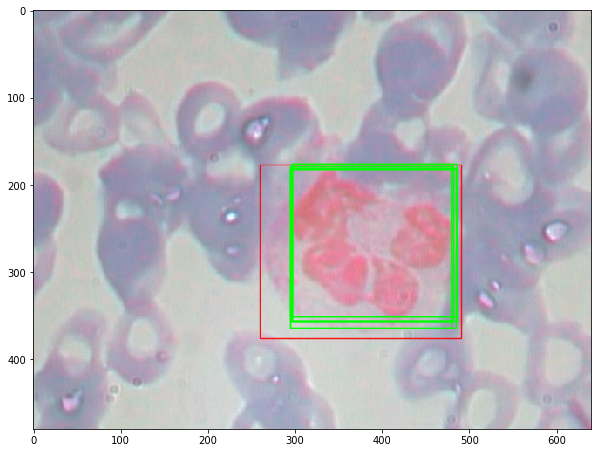

In [13]:
im = cv2.imread(df.values[0][0])
rects=all_rects[0]
# number of region proposals to show
numShowRects = 10

# create a copy of original image
imOut = im.copy()
x_min,x_max,y_min,y_max= df.values[0][2:]
cv2.rectangle(imOut, (x_min,y_min), (x_max, y_max), (255, 0, 0), 1, cv2.LINE_AA)
# itereate over all the region proposals
for i, rect in enumerate(rects):
            # draw rectangle for region proposal till numShowRects
            if (i < numShowRects):
                x, y, w, h = rect
                cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            else:
                break
plt.figure(figsize=(10,10))
# show output
plt.imshow(imOut)


#ImageNet

In [0]:
import keras
import cv2
import numpy as np
import sys
import os
import argparse

In [0]:
default_model_name = 'keras_alexnet.h5'
default_model_dir = 'models'

In [0]:
def build_model(image_height=224, image_width=224, class_count=1000):
    """keras implementation of the SuperVision NN designed by Alex Krizhevsky et. al.
    NOTE: this implementation deviates from the original design in two ways:
        1) the original was architected to operate distributedly across two systems (this implementation is not distributed)
        2) keras Batch Normalization is used in-place of the original Alexnet's local response normalization
    https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
    http://vision.stanford.edu/teaching/cs231b_spring1415/slides/alexnet_tugce_kyunghee.pdf
    http://image-net.org/challenges/LSVRC/2012/supervision.pdf
    :return: assembled alexnet/supervision keras model
    """
    model = keras.models.Sequential()

    # layer 1 - "filters the 224 x 224 x 3 input image with 96 kernels
    #           of size 11 x 11 x 3 with a stride of 4 pixels"
    model.add(keras.layers.Conv2D(filters=96,
                                  kernel_size=(11, 11),
                                  strides=4,
                                  input_shape=(image_height, image_width, 3),
                                  activation="relu",
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(3, 3),
                                     strides=(2, 2)))

    # layer 2 - "256 kernels of size 5 x 5 x 48"
    model.add(keras.layers.Conv2D(filters=256,
                                  kernel_size=(5, 5),
                                  activation="relu",
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(3, 3),
                                     strides=(2, 2)))

    # layer 3 - "384 kernels of size 3 x 3 x 256"
    model.add(keras.layers.Conv2D(filters=384,
                                  kernel_size=(3, 3),
                                  activation="relu",
                                  padding="same"))
    # layer 4 - "384 kernels of size 3 x 3 x 192"
    model.add(keras.layers.Conv2D(filters=384,
                                  kernel_size=(3, 3),
                                  activation="relu",
                                  padding="same"))
    # layer 5 - "256 kernels of size 3 x 3 x 192"
    model.add(keras.layers.Conv2D(filters=256,
                                  kernel_size=(3, 3),
                                  activation="relu",
                                  padding="same"))
    model.add(keras.layers.MaxPool2D(pool_size=(3, 3),
                                     strides=(2, 2)))

    # flatten before feeding into FC layers
    model.add(keras.layers.Flatten())

    # fully connected layers
    # "The fully-connected layers have 4096 neurons each."
    # "We use dropout in the first two fully-connected layers..."
    model.add(keras.layers.Dense(units=4096))  # layer 6
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(units=4096))  # layer 7
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(units=class_count))  # layer 8

    # output layer is softmax
    model.add(keras.layers.Activation('softmax'))
    return model


In [0]:
def preprocess_image(image, image_height=224, image_width=224):
    """resize images to the appropriate dimensions
    :param image_width:
    :param image_height:
    :param image: image
    :return: image
    """
    return cv2.resize(image, (image_height, image_width))


def load_dataset():
    """loads training and testing resources
    :return: x_train, y_train, x_test, y_test
    """
    return keras.datasets.cifar100.load_data(label_mode='fine')


def generator(batch_size, class_count, image_height, image_width, x_data, y_data):
    """generates batch training (and evaluating) data and labels
    """
    while True:
        X = []  # batch training set
        Y = []  # batch labels
        for index in range(0, len(x_data)):
            X.append(preprocess_image(x_data[index], image_height, image_width))
            Y.append(y_data[index])
            if (index + 1) % batch_size == 0:
                yield np.array(X), keras.utils.to_categorical(np.array(Y), class_count)
                X = []
                Y = []




In [0]:
"""build, train, and test an implementation of the alexnet CNN model in keras.
    This model is trained and tested on the CIFAR-100 dataset
    """
model_path = "model"
epochs = 90
model = build_model(class_count=100)

In [0]:
def train_model(model, image_height=224, image_width=224, class_count=1000, epochs=90):
    """train the SuperVision/alexnet NN model
    :param epochs:
    :param image_height:
    :param class_count:
    :param image_width:
    :param model: NN model (uncompiled, without weights)
    :return: compiled NN model with weights
    """
    # compile with SGD optimizer and categorical_crossentropy as the loss function
    model.compile(loss="categorical_crossentropy",
                  optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, decay=0.0005),
                  metrics=['accuracy'])

    # training parameters
    (x_train, y_train), (x_test, y_test) = load_dataset()
    batch_size = 128
    steps = len(x_train) / batch_size

    # train the model using a batch generator
    batch_generator = generator(batch_size, class_count, image_height, image_width, x_train, y_train)
    model.fit_generator(generator=batch_generator,
                        steps_per_epoch=steps,
                        epochs=epochs,
                        verbose=1)

    # train the model on the dataset
    # count=10000
    # x_train = np.array([preprocess_image(image) for image in x_train[:count]])
    # y_train = keras.utils.to_categorical(y_train[:count], class_count)
    # model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs)

In [0]:
def evaluate(model, class_count=1000, image_height=224, image_width=224):
    """evaluate the performance of the trained model using the prepared testing set
    :param image_width:
    :param class_count:
    :param image_height:
    :param model: compiled NN model with trained weights
    """

    # training parameters
    (x_train, y_train), (x_test, y_test) = load_dataset()
    batch_size = 128
    steps = len(x_test) / batch_size

    # train the model using a batch generator
    batch_generator = generator(batch_size, class_count, image_height, image_width, x_test, y_test)
    scores = model.evaluate_generator(generator=batch_generator,
                                      #verbose=1,
                                      steps=steps)
    print("Test Loss:\t", scores[0])
    print("Test Accuracy:\t", scores[1])


In [0]:
train_model(model, class_count=100, epochs=epochs)

# test the model
evaluate(model, class_count=100)

    # save the trained model
model.save(model_path)
print("Alexnet model saved to: %s" % model_path)

In [0]:
model.save("Pretrained.h5")
print("Alexnet model saved to: %s" % model_path)

#Extract $\phi(x,y)$

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)      

In [0]:
from keras.models import Model

  # include here your original model

layer_name = 'max_pooling2d_3'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)


In [0]:
all_features=[]
for i,row in enumerate(df.copy().values):
  im = cv2.imread(row[0])

  bboxes=all_bboxes[i]
  features=[]
  for box in bboxes:
    x_min,x_max,y_min,y_max= box
    patch=cv2.resize(im[y_min:y_max,x_min:x_max], (224, 224)) 
    features.append(intermediate_layer_model.predict(patch.reshape(-1,224, 224,3)).reshape(-1))
  all_features.append(features)
